#### 0. Notes
- This notebook is written for Google Colab.
- Dataset will be downloaded to ../content/data.
- Uses Hugging Face transformers + datasets + torch.
- This notebook is ran by T4 GPU.


#### 1. Install Dependencies and Import Libraries

In [46]:
# install and update required packages that are not included in the standard Colab environment
!pip install evaluate
!pip install -U "transformers>=4.38.0" "datasets>=2.15.0" "evaluate>=0.4.0" "accelerate>=0.26.0"

In [47]:
# import libraries
import shutil
import tarfile
import urllib.request
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
from datasets import load_dataset
import evaluate
from transformers import (
    AutoImageProcessor,
    ViTForImageClassification,
    DefaultDataCollator,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)
import os
os.environ["WANDB_DISABLED"] = "true"

# disable wandb to avoid noise in Colab logs
os.environ["WANDB_MODE"] = "disabled"

#### 2. Download and Extract Stanford Dogs Dataset

In [48]:
# where all downloaded data will go
DATA_DIR = "/content/data"

# where folder containing images subfolders will go
IMAGES_ROOT = os.path.join(DATA_DIR, "Images")

# where folder of annotations will go
ANNOT_ROOT  = os.path.join(DATA_DIR, "Annotation")

# create the directory if it doesn't exist yet
os.makedirs(DATA_DIR, exist_ok=True)

# download the images and annotate tars
IMAGES_URL = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
ANNOT_URL  = "http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar"

# where to save image tar file into images folder
IMAGE_TAR_PATH = os.path.join(DATA_DIR, "images.tar")

# where to save annotation file into annotation folder
ANNOT_TAR_PATH = os.path.join(DATA_DIR, "annotation.tar")

# function to download the file
def download(url, path):
    if os.path.exists(path):
        print(f"{path} already exists, skipping download.")
        return
    print(f"Downloading {url} ...")
    urllib.request.urlretrieve(url, path)
    print("Done!\n")
# download images if not already downloaded
download(IMAGES_URL, IMAGE_TAR_PATH)
# download annotations if not already downloaded
download(ANNOT_URL, ANNOT_TAR_PATH)

# function to extarct the tar files that were downloaded
def extract(tar_path, extract_to):
    print(f"Extracting {tar_path} ...")
    with tarfile.open(tar_path) as tar:
        tar.extractall(extract_to)
    print("Done!\n")
# extracts the data if it wasn't extracted already
extract(IMAGE_TAR_PATH, DATA_DIR)
extract(ANNOT_TAR_PATH, DATA_DIR)

/content/data/images.tar already exists, skipping download.
/content/data/annotation.tar already exists, skipping download.
Extracting /content/data/images.tar ...


/tmp/ipython-input-2025138343.py:40: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(extract_to)


Done!

Extracting /content/data/annotation.tar ...
Done!



#### 3. Sort Breeds Alphabetically and Build Class-Index Mapping

In [49]:
# sort the breed folders
if not os.path.exists(IMAGES_ROOT):
    raise FileNotFoundError(f"{IMAGES_ROOT} not found. Check extraction paths.")

# sort the breeds alphabetically
breeds = sorted(os.listdir(IMAGES_ROOT))

# prints number of breeds
print("Number of breeds:", len(breeds))
# prints the first 10 breed names
print("First 10 breeds:", breeds[:10], "\n")

# mapping from breed to index based on sorted order
class_to_idx = {breed: idx for idx, breed in enumerate(breeds)}

Number of breeds: 120
First 10 breeds: ['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound'] 



#### 4. Pair Images With Annotations and Verify Counts

In [50]:
# lists to store images and labels
images = []
labels = []

for breed in breeds: # to loop through each breed folder
    breed_img_dir   = os.path.join(IMAGES_ROOT, breed) # path for each image folder
    breed_annot_dir = os.path.join(ANNOT_ROOT, breed) # path for eah annotation folder

     # to list all the images for breed at the moment
    image_files = glob.glob(os.path.join(breed_img_dir, "*.jpg"))

    # for each file, extract the filename
    for img_path in image_files:
        base = os.path.splitext(os.path.basename(img_path))[0]

        # to check that annotation folder exists (latest tar format)
        annot_folder = os.path.join(breed_annot_dir, base)
        if not os.path.exists(annot_folder):
            print("Missing annotation for:", img_path)
            continue # if not missing annotation proceeds with a warning
        # if annotation, append to images and labels properly
        images.append(img_path)
        labels.append(class_to_idx[breed])

print("Total usable images:", len(images))

# an example entry
if len(images) > 0:
    print("\nExample image path:", images[0])
    print("Label index:", labels[0])
    print("Breed:", breeds[labels[0]])
else:
    print("No images were successfully paired. Check extraction paths.")

Total usable images: 20580

Example image path: /content/data/Images/n02085620-Chihuahua/n02085620_712.jpg
Label index: 0
Breed: n02085620-Chihuahua


#### 5. Visualize Sample Images and Label Assignments

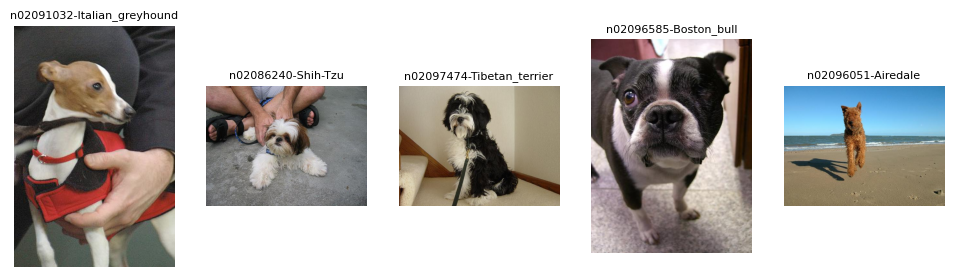

In [51]:
# code to check output of labels
import matplotlib.pyplot as plt
# import numpy to
import numpy as np
import random
from PIL import Image

# sample 5 images randomly and print image and label
sample_indices = random.sample(range(len(images)), 5)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(sample_indices):
    img = Image.open(images[idx])
    label = labels[idx]
    breed_name = breeds[label]

    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(breed_name, fontsize=8)
    plt.axis('off')
plt.show()

#### 6. Plot Class Distribution for All Breeds


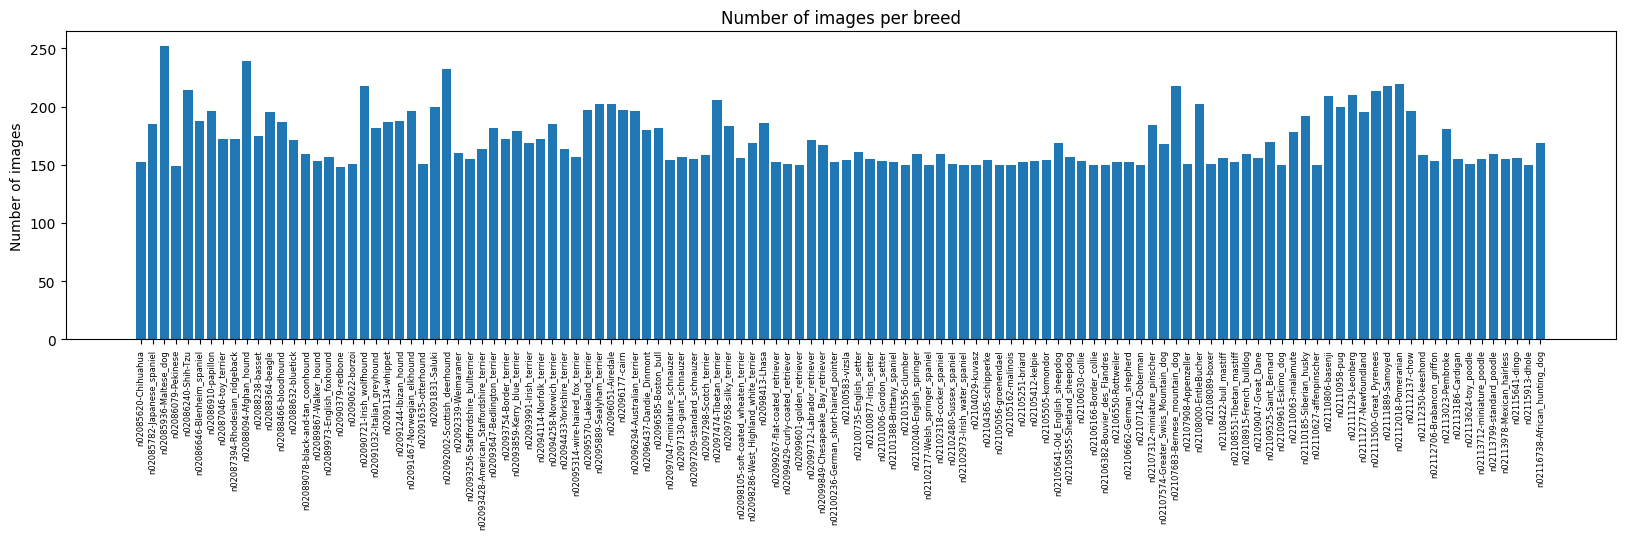

In [52]:
# get counts for each breeds
counts = [labels.count(i) for i in range(len(breeds))]

# plotting
plt.figure(figsize=(20,4))
plt.bar(range(len(breeds)), counts)
plt.xticks(range(len(breeds)), breeds, rotation=90, fontsize=6)
plt.ylabel("Number of images")
plt.title("Number of images per breed")
plt.show()

In [53]:
# to ensure there are 120 labels used
unique_labels = set(labels)
print("Number of unique labels:", len(unique_labels))
assert len(unique_labels) == len(breeds)
# assertion works and is good

Number of unique labels: 120


In [54]:
# check a breed
# do chiuahua since it was given in one of the ouput above
breed_to_check = "n02085620-Chihuahua"
breed_idx = class_to_idx[breed_to_check]

# get all images with this label
breed_images = [img for img, lbl in zip(images, labels) if lbl == breed_idx]

print(f"Number of images labeled {breed_to_check}: {len(breed_images)}")
print("First 5 image paths:", breed_images[:5])

Number of images labeled n02085620-Chihuahua: 152
First 5 image paths: ['/content/data/Images/n02085620-Chihuahua/n02085620_712.jpg', '/content/data/Images/n02085620-Chihuahua/n02085620_4919.jpg', '/content/data/Images/n02085620-Chihuahua/n02085620_10131.jpg', '/content/data/Images/n02085620-Chihuahua/n02085620_4602.jpg', '/content/data/Images/n02085620-Chihuahua/n02085620_4572.jpg']


#### 7. Select Top 20 Most Frequent Breeds

In [55]:
# decrease to 20 most frequently occurring breeds

breed_counts = []

for breed in os.listdir(IMAGES_ROOT):
    breed_path = os.path.join(IMAGES_ROOT, breed)

    # count jpg files
    n_images = sum(
        f.lower().endswith(".jpg")
        for f in os.listdir(breed_path)
    )

    breed_counts.append((breed, n_images))

# sort by freq (desc)
breed_counts.sort(key=lambda x: x[1], reverse=True)

# select top 20
selected_breeds = [breed for breed, count in breed_counts[:20]]

print("Selected breeds (top 20):")
print(selected_breeds)

# filter
breeds = selected_breeds

Selected breeds (top 20):
['n02085936-Maltese_dog', 'n02088094-Afghan_hound', 'n02092002-Scottish_deerhound', 'n02112018-Pomeranian', 'n02090721-Irish_wolfhound', 'n02107683-Bernese_mountain_dog', 'n02111889-Samoyed', 'n02086240-Shih-Tzu', 'n02111500-Great_Pyrenees', 'n02111129-Leonberg', 'n02110806-basenji', 'n02097474-Tibetan_terrier', 'n02095889-Sealyham_terrier', 'n02108000-EntleBucher', 'n02096051-Airedale', 'n02091831-Saluki', 'n02110958-pug', 'n02096177-cairn', 'n02095570-Lakeland_terrier', 'n02086910-papillon']


#### 8. Load Pretrained ViT Processor (Hugging Face)

In [56]:
# import code pulled from HuggingFace

from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: Egyptian cat


#### 9. Split Images into Train/Validation/Test Folders

In [57]:
# import progress bar
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split


OUTPUT_DIR = os.path.join(DATA_DIR, "data_splits")
os.makedirs(OUTPUT_DIR, exist_ok=True)

train_dir = os.path.join(OUTPUT_DIR, "train")
val_dir = os.path.join(OUTPUT_DIR, "val")
test_dir = os.path.join(OUTPUT_DIR, "test")

for d in [train_dir, val_dir, test_dir]:
    os.makedirs(d, exist_ok=True)

# # need to sort breeds
# breeds = sorted(os.listdir(IMAGES_ROOT))


for breed in tqdm(breeds, desc="Splitting breeds"):
    breed_path = os.path.join(IMAGES_ROOT, breed)

    # all image paths for this breed
    image_files = [
        os.path.join(breed_path, f)
        for f in os.listdir(breed_path)
        if f.lower().endswith(".jpg")
    ]

    # create splits now

    # 70% train, 15% val, 15% test for splits
    train_imgs, temp_imgs = train_test_split(
        image_files, test_size=0.30, random_state=42
    )
    val_imgs, test_imgs = train_test_split(
        temp_imgs, test_size=0.50, random_state=42
    )

    # output breed folders
    for split_name, split_imgs in zip(["train", "val", "test"],
                                      [train_imgs, val_imgs, test_imgs]):

        split_breed_folder = os.path.join(OUTPUT_DIR, split_name, breed)
        os.makedirs(split_breed_folder, exist_ok=True)

        # copy images to proper split folder
        for img_path in split_imgs:
            shutil.copy(img_path, split_breed_folder)

print("Dataset split complete!")
print(f"Train directory: {train_dir}")
print(f"Val directory:   {val_dir}")
print(f"Test directory:  {test_dir}")

Splitting breeds: 100%|██████████| 20/20 [00:00<00:00, 23.20it/s]

Dataset split complete!
Train directory: /content/data/data_splits/train
Val directory:   /content/data/data_splits/val
Test directory:  /content/data/data_splits/test


In [58]:
# sanity check for decrease to 20 breeds
for split in ["train", "val", "test"]:
    breeds_in_split = sorted(os.listdir(os.path.join(OUTPUT_DIR, split)))
    print(split, len(breeds_in_split), "breeds")
    print(breeds_in_split)

train 20 breeds
['n02085936-Maltese_dog', 'n02086240-Shih-Tzu', 'n02086910-papillon', 'n02088094-Afghan_hound', 'n02090721-Irish_wolfhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02095570-Lakeland_terrier', 'n02095889-Sealyham_terrier', 'n02096051-Airedale', 'n02096177-cairn', 'n02097474-Tibetan_terrier', 'n02107683-Bernese_mountain_dog', 'n02108000-EntleBucher', 'n02110806-basenji', 'n02110958-pug', 'n02111129-Leonberg', 'n02111500-Great_Pyrenees', 'n02111889-Samoyed', 'n02112018-Pomeranian']
val 20 breeds
['n02085936-Maltese_dog', 'n02086240-Shih-Tzu', 'n02086910-papillon', 'n02088094-Afghan_hound', 'n02090721-Irish_wolfhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02095570-Lakeland_terrier', 'n02095889-Sealyham_terrier', 'n02096051-Airedale', 'n02096177-cairn', 'n02097474-Tibetan_terrier', 'n02107683-Bernese_mountain_dog', 'n02108000-EntleBucher', 'n02110806-basenji', 'n02110958-pug', 'n02111129-Leonberg', 'n02111500-Great_Pyrenees', 'n02111889-Samoye

In [59]:
# to double check the counts per image split
for split in ["train", "val", "test"]:
    total = sum(len(files) for _, _, files in os.walk(os.path.join(OUTPUT_DIR, split)))
    print(split, total)


train 2963
val 637
test 644


In [60]:
# check that the total number of breeds is preseved
print(len(os.listdir(train_dir)), "breeds in train")
print(len(os.listdir(val_dir)),   "breeds in val")
print(len(os.listdir(test_dir)),  "breeds in test")

# all 20 breeds in each split data

20 breeds in train
20 breeds in val
20 breeds in test


#### 10. Convert Splits to HuggingFace Dataset

In [61]:
# convert split folders to Hugging Face datasets and prepare transforms for Trainer

from torchvision import transforms
import os

IMG_SIZE = 224
BATCH_SIZE = 8  # per-device batch size for Trainer

OUTPUT_DIR = os.path.join(DATA_DIR, "data_splits")
absolute_output_dir = os.path.abspath(OUTPUT_DIR)

train_data_path = os.path.join(absolute_output_dir, "train")
val_data_path = os.path.join(absolute_output_dir, "val") # Assuming 'val' is the actual folder name created in the previous step
test_data_path = os.path.join(absolute_output_dir, "test")

print(f"Checking for train data path: {train_data_path} (exists: {os.path.exists(train_data_path)})")
print(f"Checking for val data path: {val_data_path} (exists: {os.path.exists(val_data_path)})")
print(f"Checking for test data path: {test_data_path} (exists: {os.path.exists(test_data_path)})")

if not os.path.exists(train_data_path) or not os.path.exists(val_data_path) or not os.path.exists(test_data_path):
    raise FileNotFoundError(
        f"One or more required data split directories (train, val, test) not found within "
        f"{absolute_output_dir}. Please ensure cell '3ec61025' was executed correctly "
        f"and created these directories with content. If the directories exist, there might be a naming mismatch (e.g., 'validation' vs 'val')."
    )

# use data_files explicitly with glob patterns to ensure all image files are found within subdirectories.
data_files = {
    "train": os.path.join(train_data_path, "**", "*.jpg"),
    "validation": os.path.join(val_data_path, "**", "*.jpg"),
    "test": os.path.join(test_data_path, "**", "*.jpg"),
}

dataset = load_dataset("imagefolder", data_files=data_files)
# rename to the column name Trainer expects
dataset = dataset.rename_column("label", "labels")

labels = dataset["train"].features["labels"].names
label2id = {label: idx for idx, label in enumerate(labels)}
id2label = {idx: label for label, idx in label2id.items()}

checkpoint = "google/vit-base-patch16-224"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

model = ViTForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,
)

normalize = transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = image_processor.size.get("shortest_edge") or image_processor.size.get("height", IMG_SIZE)

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

eval_transforms = transforms.Compose([
    transforms.Resize(size + 32),
    transforms.CenterCrop(size),
    transforms.ToTensor(),
    normalize,
])

def apply_train_transforms(batch):
    pixel_values = [train_transforms(img.convert("RGB")) for img in batch["image"]]
    return {"pixel_values": pixel_values, "labels": batch["labels"]}

def apply_eval_transforms(batch):
    pixel_values = [eval_transforms(img.convert("RGB")) for img in batch["image"]]
    return {"pixel_values": pixel_values, "labels": batch["labels"]}

train_ds = dataset["train"].with_transform(apply_train_transforms)
val_ds = dataset["validation"].with_transform(apply_eval_transforms)
test_ds = dataset["test"].with_transform(apply_eval_transforms)

data_collator = DefaultDataCollator()


Checking for train data path: /content/data/data_splits/train (exists: True)
Checking for val data path: /content/data/data_splits/val (exists: True)
Checking for test data path: /content/data/data_splits/test (exists: True)


Resolving data files:   0%|          | 0/2963 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/637 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/644 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([20]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([20, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### 11. Baseline ViT Model Training

---



In [62]:
# train the model using Hugging Face Trainer

from transformers import EarlyStoppingCallback

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return metric.compute(predictions=preds, references=labels)

training_args = TrainingArguments(
    output_dir="./vit-dog-breed-checkpoints",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,

    # enable validation each epoch
    eval_strategy="epoch",
    save_strategy="epoch",

    # save the best checkpoint
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,

    num_train_epochs=10,
    learning_rate=5e-6,
    weight_decay=0.01,
    logging_steps=50,

    remove_unused_columns=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

train_result = trainer.train()
val_result = trainer.evaluate()


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-2401845048.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.752400,1.492762,0.847724
2,0.926700,0.677192,0.949765
3,0.587400,0.383898,0.965463
4,0.444800,0.266744,0.970173
5,0.341300,0.206747,0.971743
6,0.297100,0.175976,0.978022
7,0.262000,0.156561,0.974882
8,0.288900,0.147219,0.978022
9,0.260700,0.142827,0.979592
10,0.249300,0.141013,0.978022


#### 12. Single Training Batch Inspection

In [63]:
# inspect a single training batch after preprocessing
batch = next(iter(trainer.get_train_dataloader()))
print("pixel_values shape:", batch["pixel_values"].shape)
print("labels shape:", batch["labels"].shape)


pixel_values shape: torch.Size([8, 3, 224, 224])
labels shape: torch.Size([8])


#### 13. Visualize Training Progress

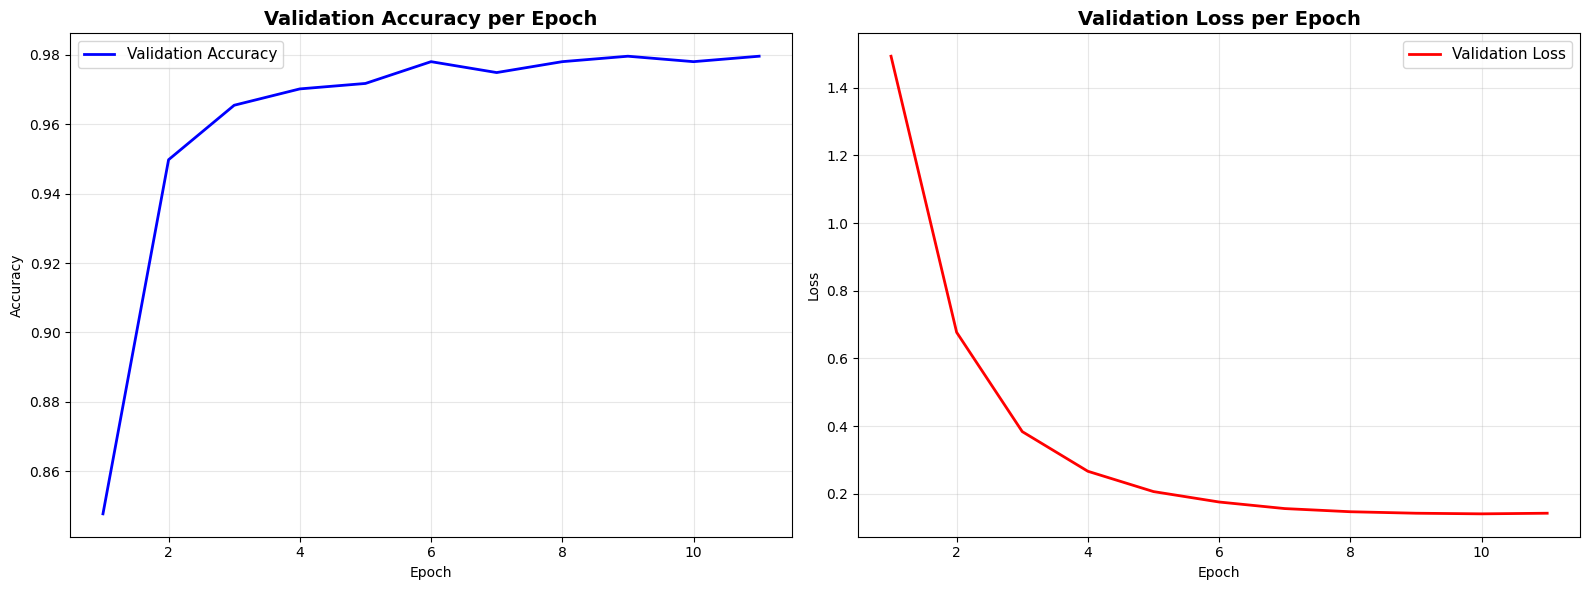

  Training Summary
  Best Validation Accuracy: 0.9796
  Best Validation Loss:     0.1410


In [64]:
import matplotlib.pyplot as plt

# pull eval metrics logged each epoch
log_history = trainer.state.log_history
eval_loss = [log["eval_loss"] for log in log_history if "eval_loss" in log]
eval_accuracy = [log.get("eval_accuracy") for log in log_history if "eval_accuracy" in log]

if not eval_loss:
    print("No evaluation logs captured. Run trainer.train() first.")
else:
    epochs = range(1, len(eval_loss) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.plot(epochs, eval_accuracy, 'b-', linewidth=2, label="Validation Accuracy")
    ax1.set_title('Validation Accuracy per Epoch', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch'); ax1.set_ylabel('Accuracy')
    ax1.legend(fontsize=11); ax1.grid(True, alpha=0.3)

    ax2.plot(epochs, eval_loss, 'r-', linewidth=2, label="Validation Loss")
    ax2.set_title('Validation Loss per Epoch', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch'); ax2.set_ylabel('Loss')
    ax2.legend(fontsize=11); ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"{'='*60}")
    print("  Training Summary")
    print(f"{'='*60}")
    print(f"  Best Validation Accuracy: {max(eval_accuracy):.4f}")
    print(f"  Best Validation Loss:     {min(eval_loss):.4f}")
    print(f"{'='*60}")


#### 14. Evalute on Testing Set

Evaluating on test set with Trainer...


Test Loss: 0.1511
Test Accuracy: 0.9612
Manual Test Accuracy: 0.9612


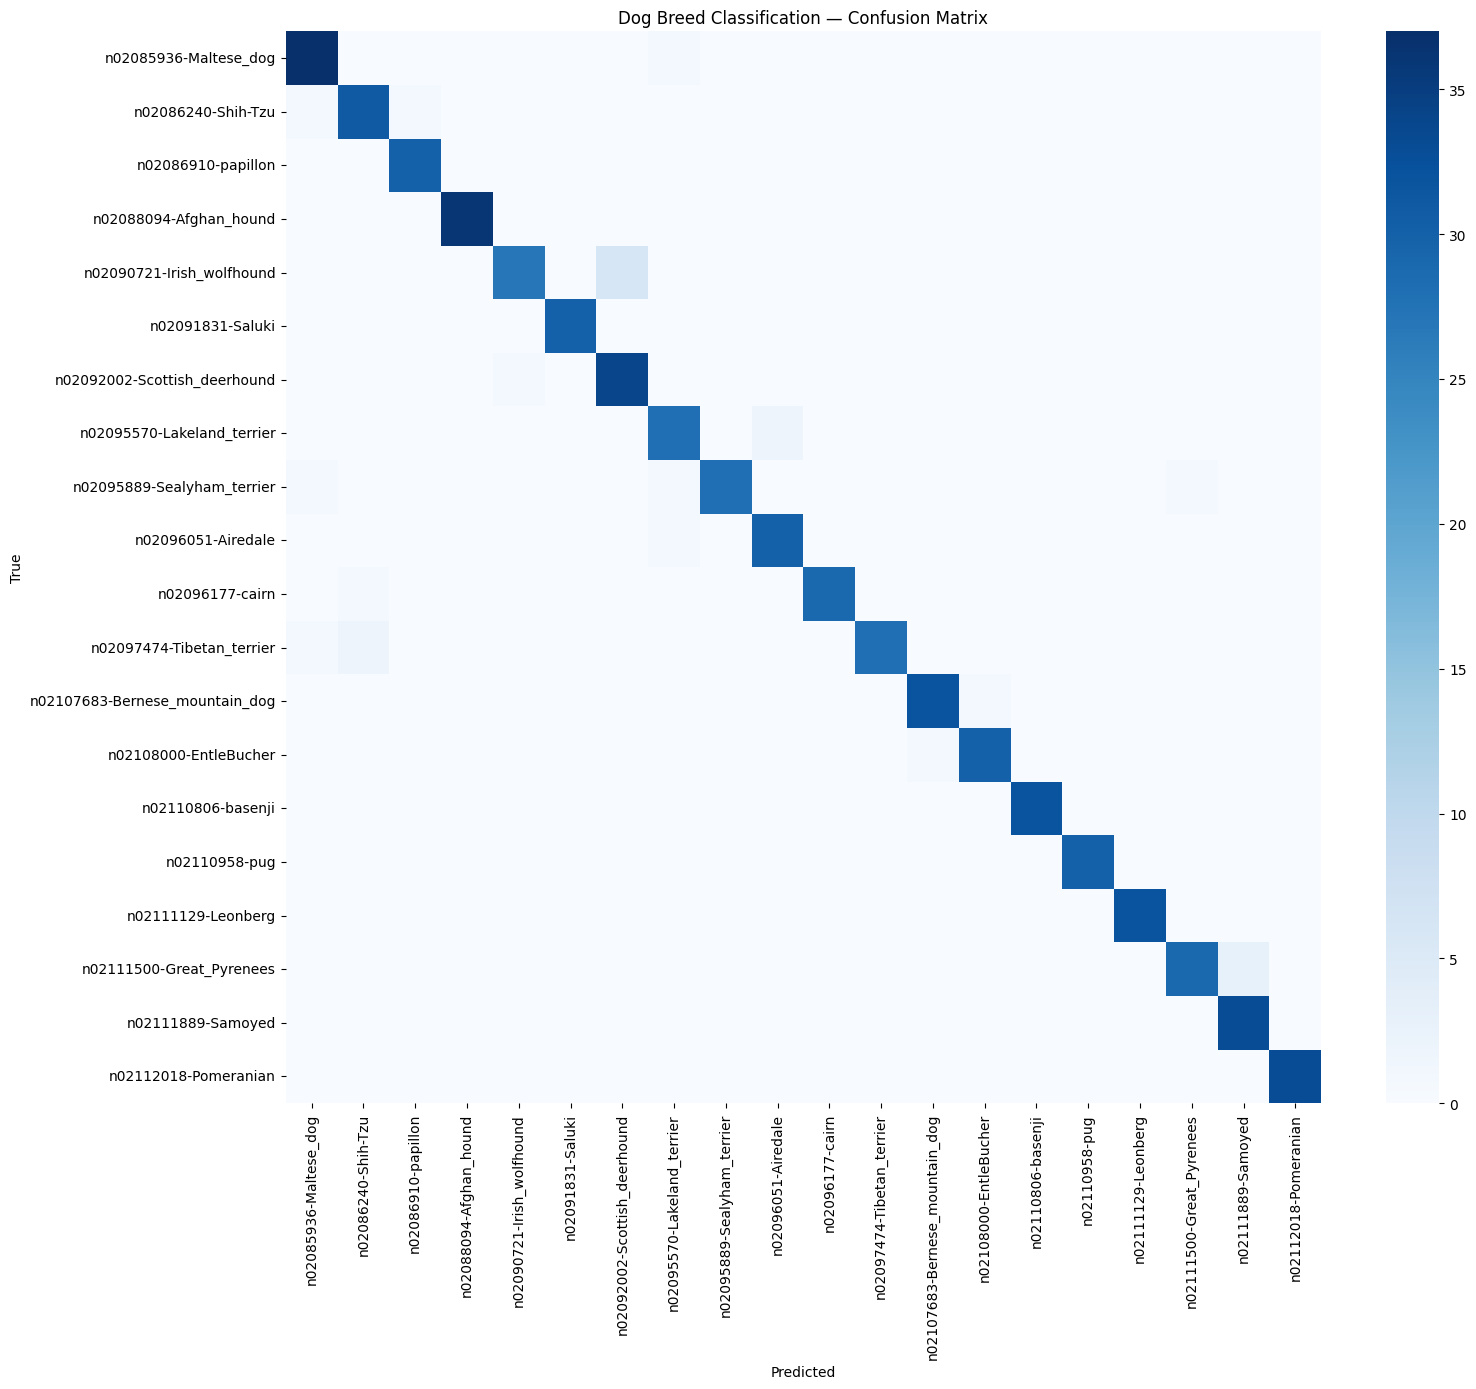

In [65]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
import matplotlib.pyplot as plt

print("Evaluating on test set with Trainer...")
test_metrics = trainer.evaluate(test_ds)
print(f"Test Loss: {test_metrics['eval_loss']:.4f}")
print(f"Test Accuracy: {test_metrics['eval_accuracy']:.4f}")

preds_output = trainer.predict(test_ds)
y_true = preds_output.label_ids
y_pred = preds_output.predictions.argmax(axis=-1)

# Manual accuracy
accuracy = (y_pred == y_true).mean()
print(f"Manual Test Accuracy: {accuracy:.4f}")

cm = confusion_matrix(y_true, y_pred)
class_names = labels

plt.figure(figsize=(16, 14))
sns.heatmap(
    cm,
    annot=False,
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title("Dog Breed Classification — Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
